In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [10]:
file = "../data/nexus/LPR_Tl208_Ports/NEXT100_Tl208_Port1a_nexus_4bar.h5"

particles = pd.read_hdf(file, "MC/particles")
all_hits = pd.read_hdf(file, "MC/hits")


events = particles.event_id.unique()
print(events)

KeyboardInterrupt: 

In [ ]:
# Choose your event index here (or use event)
# event = events[503]
# print(event)
# event = 90184 # This is the multiple compton event

event = events[110]

# event = 4965014

parts = particles[particles.event_id == event]
hits = all_hits[all_hits.event_id == event]

In [ ]:
pd.set_option('display.max_rows', 600) 
display(parts[["particle_id","particle_name", "primary", "mother_id","kin_energy",  "initial_x", "initial_y", "initial_z", "final_volume"]])
# display(hits)

,particle_id,particle_name,primary,mother_id,kin_energy,initial_x,initial_y,initial_z,final_volume
7106147,1,Tl208,1,0,0.000000e+00,399.163971,401.371613,564.221924,TH228
7106148,4,e-,0,1,9.867474e-01,399.163971,401.371613,564.221924,TH228
7106149,3,anti_nu_e,0,1,3.036768e-01,399.163971,401.371613,564.221924,WORLD
7106150,2,Pb208[3708.451],0,1,4.808826e-06,399.163971,401.371613,564.221924,TH228
7106151,6,gamma,0,2,5.107393e-01,399.163971,401.371613,564.221924,ICS
7106152,13,e-,0,6,5.768000e-05,373.757721,469.809143,524.902710,ICS
7106153,12,e-,0,6,9.386400e-04,373.757721,469.809143,524.902710,ICS
7106154,11,e-,0,6,7.906810e-03,373.757721,469.809143,524.902710,ICS
7106155,10,e-,0,6,1.792402e-01,373.757721,469.809143,524.902710,ICS
7106156,9,e-,0,6,5.071984e-02,370.273041,469.346588,523.664856,ICS


In [ ]:
# Add the mother id and mother creator proc information to the hits table
parts_mothers = parts[["particle_name","particle_id","mother_id", "creator_proc"]] # useful columns for identifying the mothers
hits_merged  = pd.merge(hits, parts_mothers, on='particle_id', how='inner')

# display(hits_merged)


# ----------------------------------------------------------------------------------------------------
def CallGetParentCreators(hits_merged, label):

    eioni = len(hits_merged[ (hits_merged.creator_proc == label)])
    while(eioni >0):
        hits_merged = GetParentCreators(hits_merged, parts_mothers, label)
        eioni = len(hits_merged[(hits_merged.creator_proc == label)])

    return hits_merged
# ----------------------------------------------------------------------------------------------------
# Function to get the creator proc, if eIoni or msc, then need to find the parent process
def GetParentCreators(hits_merged, parts_mothers, label):
    ioni_proc = hits_merged # hits merged here only contains eIoni or msc rows
    ioni_proc = ioni_proc[["event_id","mother_id"]]

    parts_mothers_slim = parts_mothers[["particle_id","mother_id"]]

    # Merge the mother information to the eIoni columns
    ioni_proc_mother_merged = pd.merge(
        ioni_proc.reset_index(), 
        parts_mothers, 
        left_on='mother_id', 
        right_on='particle_id', 
        how='inner'
    )

    # Fix the indexing
    ioni_proc_mother_merged = ioni_proc_mother_merged[["index", "creator_proc"]]
    ioni_proc_mother_merged = ioni_proc_mother_merged.set_index("index", drop=True)
    ioni_proc_mother_merged.index.name = None

    # join the tables and then replace the eIoni with the parent creator if eIoni
    hits_merged = pd.merge(hits_merged, ioni_proc_mother_merged, left_index=True, right_index=True, how='inner')
    hits_merged['creator_proc_x'] = np.where(hits_merged['creator_proc_x'] == label, hits_merged['creator_proc_y'], hits_merged['creator_proc_x'])
    
    # Need to update the mother ids
    hits_merged['particle_id'] = np.where(hits_merged['creator_proc_x'] == label, hits_merged['mother_id'], hits_merged['particle_id']) # Update the particle_id and mother id
    hits_merged = hits_merged.drop(['mother_id'], axis=1)
    hits_merged  = pd.merge(hits_merged, parts_mothers_slim, on='particle_id', how='inner')

    hits_merged = hits_merged.drop(['creator_proc_y'], axis=1)
    hits_merged.rename(columns={'creator_proc_x': 'creator_proc'}, inplace=True)

    return hits_merged

# ----------------------------------------------------------------------------------------------------
# Calculate the distance from neighbouring points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

def calculate_distance(row1, row2):
    return np.sqrt((row1['x'] - row2['x'])**2 + (row1['y'] - row2['y'])**2 + (row1['z'] - row2['z'])**2)
# ----------------------------------------------------------------------------------------------------
# Function to merge group ids if their distance is less than some threshold
def MergeGroups(df, distance_threshold):
    while True:
        merged = False
        unique_groups = df['group'].unique()
        
        for group in unique_groups:
            current_group_hits = df[df['group'] == group]
            other_hits = df[df['group'] != group]
            
            for _, current_hit in current_group_hits.iterrows():
                # Calculate distances to all other hits
                distances = other_hits.apply(
                    lambda other_hit: calculate_distance(current_hit, other_hit), axis=1
                )
                
                # Find the closest hit
                min_distance = distances.min()
                if min_distance <= distance_threshold:
                    closest_hit_group = other_hits.loc[distances.idxmin(), 'group']
                    
                    # Merge the groups
                    df.loc[df['group'] == closest_hit_group, 'group'] = group
                    merged = True
        
        # Break the loop if no more groups are merged
        if not merged:
            break
    
    return df
# ----------------------------------------------------------------------------------------------------
# Function groups hits that are within ~ 1 step length together
# Will assign a new group, assumes neighbouring hits are created by same particle
def GetGroups(hits_merged):

    electrons = hits_merged[(hits_merged.particle_name == "e-") | (hits_merged.particle_name == "e+") ]

    distance_cut = 1.5 # mm -- max step size is 1 mm

    # Loop over unique mothers
    electrons["group"] = 0
    electrons = electrons.reset_index(drop=True)

    group_index = 0

    # Loop over the rows
    for i in range(1, len(electrons)):
        prev_point = electrons.iloc[i - 1][['x', 'y', 'z']].to_numpy()
        curr_point = electrons.iloc[i][['x', 'y', 'z']].to_numpy()
        distance = euclidean_distance(curr_point,prev_point)

        if (distance < distance_cut):
            electrons.at[i-1, "group"] = group_index
        else:
            electrons.at[i-1, "group"] = int(group_index)
            group_index = int(group_index + 1)

        if (i == len(electrons)-1):
            electrons.at[i, "group"] = int(group_index)

    # display(electrons)
    # Merge groups that have hits within 10 mm
    electrons = MergeGroups(electrons, 3)

    # Group by 'group' and calculate mean of 'x', 'y', 'z', keep other columns
    # This collated all the hits into a row the mean positions for rows with the same group
    grouped = electrons.groupby(['group', 'mother_id']).agg({
        'event_id': 'first',  # Keep the first event_id in each group
        'x': 'mean',          # Mean of x
        'y': 'mean',          # Mean of y
        'z': 'mean',          # Mean of z
        'energy': 'sum',      # Sum of energy
        'creator_proc': 'first'
    }).reset_index()

    # Assign the same group number to all rows where creator_proc == "conv"
    # This is to fix a bug where geant4 messes up the step size
    conv_rows = grouped['creator_proc'] == 'conv'
    new_group_number = grouped.loc[conv_rows, 'group'].min()  # Use the smallest group number in those rows
    grouped.loc[conv_rows, 'group'] = new_group_number
    
    return grouped, electrons

# ----------------------------------------------------------------------------------------------------
# Identify if any of the mother ids are electrons
# If they are then look at their mother to see if its a gamma
def GetParentName(parts, id_):
    parent = parts[parts.particle_id == id_]
    parent_name = parent["particle_name"].item()
    mother_id = parent["mother_id"].item()
    particle_id = parent["particle_id"].item()
    creator_proc = parent.creator_proc.item()

    if (creator_proc == "RadioactiveDecay"):
        creator_proc="RD"
    if ( (creator_proc == "phot" or creator_proc == "eIoni") and parent_name == "gamma"):
        creator_proc="xray"


    if (parent.primary.item()==1):
        primary = True
    else:
        primary = False

    return parent_name, particle_id, mother_id, creator_proc, primary

# ----------------------------------------------------------------------------------------------------
# Now we identify if any of the mother ids are electrons. If they are
# then look for their mother to see what gamma they came from
# also get information about how that gamma was made. e.g x-ray, radioactive decay (RD) or eBrem
def GetElectronMother(grouped):
    new_labels = []
    mother_creator_procs = []
    for index, row in grouped.iterrows():
        parent_name = ""
        mother_id = row.mother_id
        while (parent_name != "gamma" or primary_flag):
            parent_name, particle_id, mother_id, creator_proc, primary_flag = GetParentName(parts, mother_id)
        new_labels.append(particle_id)
        mother_creator_procs.append(creator_proc)

    grouped["mother_id"] = new_labels
    grouped["type"]= mother_creator_procs

    print("printing before")
    display(grouped)

    # Merge rows from duplicated entries
    grouped = grouped.groupby(['mother_id', 'creator_proc', 'group'], as_index=False).agg({
        'event_id': 'first',  # Keep the first event_id in each group
        'x': 'mean',          # Mean of x
        'y': 'mean',          # Mean of y
        'z': 'mean',          # Mean of z
        'energy': 'sum',       # Sum of energy
        # 'group' : 'first',
        'type' : 'first'
    })

    # Rename some columns
    grouped.rename(columns={'mother_id': 'gamma_id'}, inplace=True)
    grouped.rename(columns={'creator_proc': 'interaction'}, inplace=True)

    return grouped

# ----------------------------------------------------------------------------------------------------
def GetMotherInfo(particle_id):
    mother = parts[parts.particle_id == particle_id]
    mother_name = mother.particle_name.item()
    mother_id = mother.mother_id.item()
    energy = mother.kin_energy.item()
    creator_proc = mother.creator_proc.item()
    primary = mother.primary.item()
    return mother_name, mother_id, energy, creator_proc, primary

# ----------------------------------------------------------------------------------------------------
# Get the particle tree up to the primary
def GetHistories(grouped):
    history_df = pd.DataFrame()

    primary = 0
    signal_flags = []
    for index in grouped.index:
        brem_flag = False
        counter = 0
        found_signal = False
        gamma_id = grouped.iloc[index].gamma_id.item()
        interaction_type = grouped.iloc[index].type
        group_index = grouped.iloc[index].group.item()
        
        mother_name, mother_id, energy, creator_proc, primary = GetMotherInfo(gamma_id)
        
        history_df = pd.concat([
        history_df, 
            pd.DataFrame({"event_id" : parts.event_id.iloc[0].item(), "group": group_index, "tree": counter ,"particle": mother_name, "particle_id": mother_id, "creator_proc":creator_proc , "energy": energy}, index=[0])
        ], ignore_index=True)
        
        # Check if the type was a brem
        if (interaction_type == "eBrem"):
            brem_flag = True

        counter = counter+1

        while (not primary):
            mother_name, mother_id, energy, creator_proc, primary = GetMotherInfo(mother_id)
            
            history_df = pd.concat([
            history_df, 
                pd.DataFrame({"event_id" : parts.event_id.iloc[0].item(), "group": group_index, "tree": counter, "particle": mother_name, "particle_id": mother_id, "creator_proc":creator_proc, "energy": energy}, index=[0])
            ], ignore_index=True)

            # Check for signal definition
            if (counter == 1 and ((mother_name == "e-") or (mother_name == "e+")) and (creator_proc == "conv" or creator_proc == "phot") and brem_flag):
                signal_flags.append(True)
                found_signal = True
            
            counter = counter+1

        if (not found_signal):
            signal_flags.append(False)
        

    grouped['signal'] = signal_flags

    return grouped, history_df

# ----------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------
# Replace ioni/msc labels with the parent interaction process. This tells us the gamma interaction that made the ionization.
hits_merged = CallGetParentCreators(hits_merged, "eIoni")
hits_merged = CallGetParentCreators(hits_merged, "msc")
# display(hits_merged)

# Group the hits based on proximities
grouped, electrons  = GetGroups(hits_merged)
# display(grouped) 

# Now we identify if any of the mother ids are electrons. If they are
# then look for their mother to see what gamma they came from
# also get information about how that gamma was made. e.g x-ray, radioactive decay (RD) or eBrem
grouped = GetElectronMother(grouped)
print("Priting group again")
display(grouped) 

# Get the particle tree up to the primary, also add signal flag to the grouped df
grouped, history_df = GetHistories(grouped)
display(history_df)
display(grouped)

print(hits.energy.sum(), grouped.energy.sum(), grouped.energy.sum()/hits.energy.sum())


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_47359/4053549577.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electrons["group"] = 0


printing before


,group,mother_id,event_id,x,y,z,energy,creator_proc,type
0,2.0,30,4965014,172.672928,91.699768,788.772766,2.015791,compt,RD
1,2.0,30,4965014,232.657898,53.466816,783.379578,0.272859,compt,RD
2,2.0,6569,4965014,378.043854,55.593868,721.595154,0.002994,phot,eBrem
3,2.0,53102,4965014,118.654022,82.300308,896.789978,0.006139,phot,eBrem
4,4.0,30,4965014,-69.041115,477.953033,780.712097,0.250585,phot,RD
5,4.0,30,4965014,-67.727722,477.107605,781.425842,0.033365,phot,RD
6,4.0,111440,4965014,-65.133659,485.354919,777.093750,0.002377,phot,eBrem
7,5.0,102862,4965014,-74.914696,479.811157,706.482666,0.028098,phot,xray


Priting group again


,gamma_id,interaction,group,event_id,x,y,z,energy,type
0,30,compt,2.0,4965014,202.665405,72.583290,786.076172,2.288650,RD
1,30,phot,4.0,4965014,-68.384415,477.530334,781.068970,0.283951,RD
2,6569,phot,2.0,4965014,378.043854,55.593868,721.595154,0.002994,eBrem
3,53102,phot,2.0,4965014,118.654022,82.300308,896.789978,0.006139,eBrem
4,102862,phot,5.0,4965014,-74.914696,479.811157,706.482666,0.028098,xray
5,111440,phot,4.0,4965014,-65.133659,485.354919,777.093750,0.002377,eBrem


,event_id,group,tree,particle,particle_id,creator_proc,energy
0,4965014,2.0,0,gamma,14,RadioactiveDecay,2.614504e+00
1,4965014,2.0,1,Pb208[2614.522],5,RadioactiveDecay,8.779753e-07
2,4965014,2.0,2,Pb208[3197.711],2,RadioactiveDecay,6.733753e-07
3,4965014,2.0,3,Pb208[3708.451],1,RadioactiveDecay,4.808826e-06
4,4965014,2.0,4,Tl208,0,none,0.000000e+00
5,4965014,4.0,0,gamma,14,RadioactiveDecay,2.614504e+00
6,4965014,4.0,1,Pb208[2614.522],5,RadioactiveDecay,8.779753e-07
7,4965014,4.0,2,Pb208[3197.711],2,RadioactiveDecay,6.733753e-07
8,4965014,4.0,3,Pb208[3708.451],1,RadioactiveDecay,4.808826e-06
9,4965014,4.0,4,Tl208,0,none,0.000000e+00


,gamma_id,interaction,group,event_id,x,y,z,energy,type,signal
0,30,compt,2.0,4965014,202.665405,72.583290,786.076172,2.288650,RD,False
1,30,phot,4.0,4965014,-68.384415,477.530334,781.068970,0.283951,RD,False
2,6569,phot,2.0,4965014,378.043854,55.593868,721.595154,0.002994,eBrem,False
3,53102,phot,2.0,4965014,118.654022,82.300308,896.789978,0.006139,eBrem,False
4,102862,phot,5.0,4965014,-74.914696,479.811157,706.482666,0.028098,xray,False
5,111440,phot,4.0,4965014,-65.133659,485.354919,777.093750,0.002377,eBrem,True


2.6130176 2.612208 0.9996901


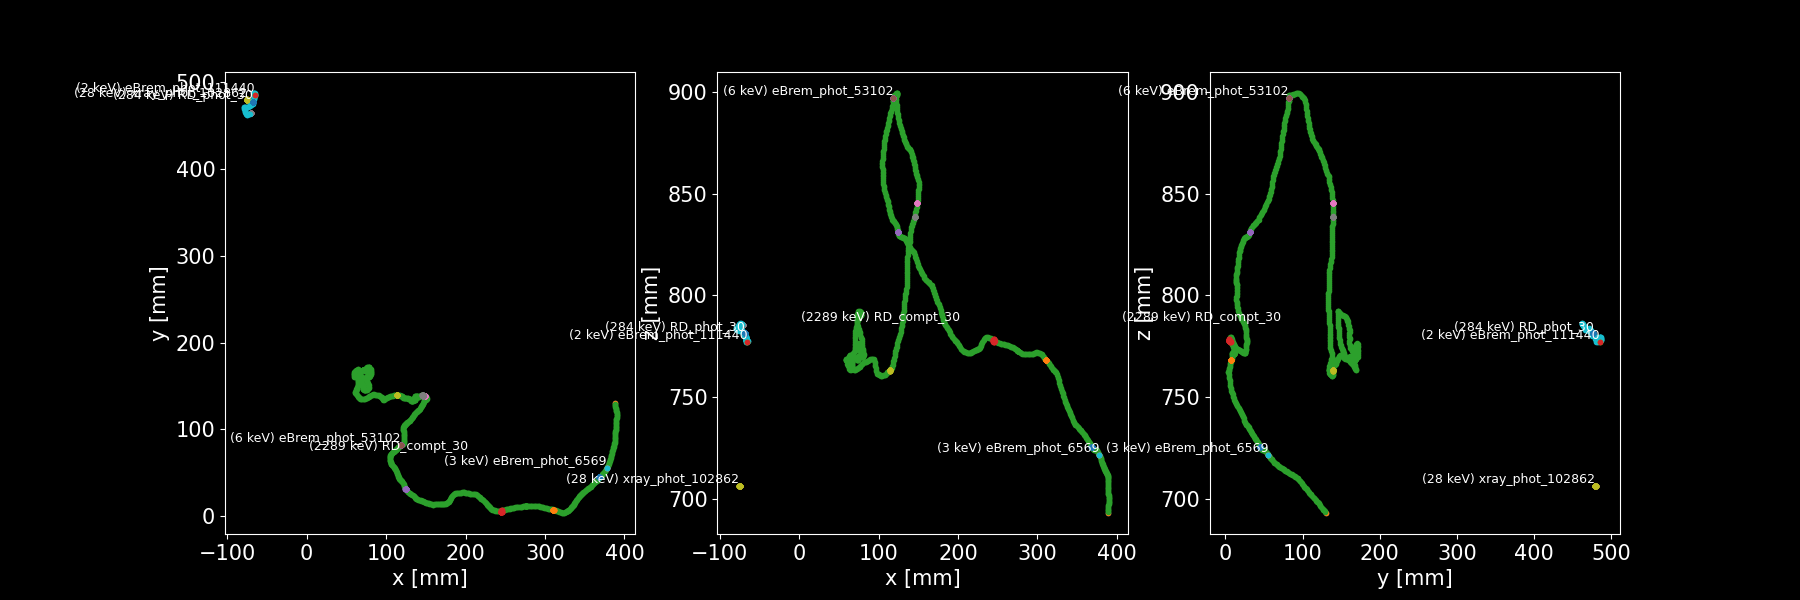

In [ ]:
%matplotlib widget

def Plot2D(ax, x_label, y_label, hits, grouped):

    fig.set_facecolor('black')
    ax.set_facecolor('black')

    for p in hits.particle_id.unique():
        ax.plot(hits[hits.particle_id == p][x_label], hits[hits.particle_id == p][y_label], ".")

    ax.set_xlabel(f"{x_label} [mm]", fontsize = 15)
    ax.set_ylabel(f"{y_label} [mm]", fontsize = 15)
    ax.tick_params(axis='both', which='both', labelsize=15)  # Adjust labelsize as needed

    # Set the color of the axes labels and ticks to white
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    # Set the color of the spines (borders) to white
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')

    for index, row in grouped.iterrows():
        Energy =round(row["energy"]*1000)
        ax.text(row[x_label], row[y_label], f"({Energy} keV) {row.type}_{row.interaction}_{row.gamma_id}", fontsize=9, ha='right', va='bottom', color='white')
        # ax.text(row[x_label]-5, row[y_label]-5, f"{Energy} keV", fontsize=9, ha='right', va='bottom', color='white')


fig, axs = plt.subplots(1, 3, figsize=(18, 6))
Plot2D(axs[0], "x", "y", hits, grouped)
Plot2D(axs[1], "x", "z", hits, grouped)
Plot2D(axs[2], "y", "z", hits, grouped)


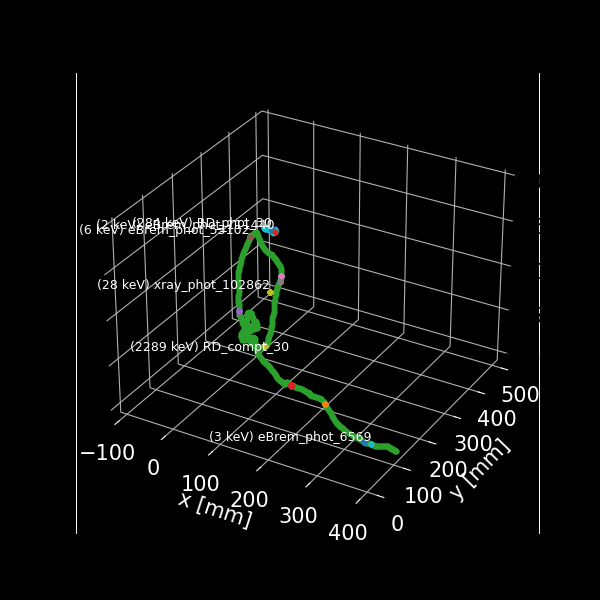

In [11]:
%matplotlib widget

fig, ax  = plt.subplots(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
fig.set_facecolor('black')
ax.set_facecolor('black')

for p in hits.particle_id.unique():
    plt.plot(hits[hits.particle_id == p].x, hits[hits.particle_id == p].y, hits[hits.particle_id == p].z,  ".")


ax.set_xlabel("x [mm]", fontsize = 15)
ax.set_ylabel("y [mm]", fontsize = 15)
ax.tick_params(axis='both', which='both', labelsize=15)  # Adjust labelsize as needed

# Set the color of the axes labels and ticks to white
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Set the color of the spines (borders) to white
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

# Set axis face colors to black
ax.xaxis.set_pane_color((0, 0, 0, 1))  # X-axis face
ax.yaxis.set_pane_color((0, 0, 0, 1))  # Y-axis face
ax.zaxis.set_pane_color((0, 0, 0, 1))  # Z-axis face

# Plot the text
for index, row in grouped.iterrows():
    Energy =round(row["energy"]*1000)
    ax.text(row["x"], row["y"], row["z"], f"({Energy} keV) {row.type}_{row.interaction}_{row.gamma_id}", fontsize=9, ha='right', va='bottom', color='white')